# **🏠 부동산 실거래가 Baseline code**
> 부동산 실거래가 예측 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 RandomForest를 활용해 ML 방법론들을 실제 대회에 적용해보도록 하겠습니다.
> 강의는 google colab으로 실행하였기에 아래의 베이스라인 코드와는 일부 차이가 있을 수 있습니다. 

## Contents
- Library Import
- Data Load
- Data Preprocessing
- Feature Engineering
- Model Training
- Inference
- Output File Save


## 1. Library Import
- 필요한 라이브러리를 불러옵니다.

In [1]:
!pip install eli5==0.13.0
!pip install xgboost
!pip install geopy

# 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 54 not upgraded.


In [2]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV

import eli5
from eli5.sklearn import PermutationImportance

2025-01-08 01:39:30.243660: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-08 01:39:30.246442: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-08 01:39:30.255025: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736300370.269031 1076223 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736300370.273278 1076223 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-08 01:39:30.288207: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## 2. Data Load

#### 2.1. 데이터 로드

In [3]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '/data/ephemeral/home/data/train.csv'
test_path  = '/data/ephemeral/home/data/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

In [4]:
# 같은 아파트명만 남기기 (test 필요)

# dt_test의 아파트명을 set으로 추출
dt_test_apartment_names = set(dt_test['아파트명'])

# dt에서 dt_test와 겹치는 아파트명만 남기기
dt = dt[dt['아파트명'].isin(dt_test_apartment_names)]

# 결과 확인
print(f"dt 데이터프레임에 남은 행 개수: {len(dt)}")
print(dt.head())  # 변경된 데이터프레임의 일부 확인

dt 데이터프레임에 남은 행 개수: 911610
             시군구     번지     본번   부번    아파트명  전용면적(㎡)    계약년월  계약일  층  건축년도  \
0  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성    79.97  201712    8  3  1987   
1  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성    79.97  201712   22  4  1987   
2  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성    54.98  201712   28  5  1987   
3  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성    79.97  201801    3  4  1987   
4  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성    79.97  201801    8  2  1987   

   ...    건축면적   주차대수 기타/의무/임대/임의=1/2/3/4                  단지승인일 사용허가여부  \
0  ...  4858.0  262.0                  임의  2022-11-17 13:00:29.0      Y   
1  ...  4858.0  262.0                  임의  2022-11-17 13:00:29.0      Y   
2  ...  4858.0  262.0                  임의  2022-11-17 13:00:29.0      Y   
3  ...  4858.0  262.0                  임의  2022-11-17 13:00:29.0      Y   
4  ...  4858.0  262.0                  임의  2022-11-17 13:00:29.0      Y   

  관리비 업로드        좌표X        좌표Y                  단지신청

In [5]:
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape)

Train data shape :  (911610, 52) Test data shape :  (9272, 51)


In [6]:
# Train과 Test data를 살펴보겠습니다.
display(dt.head(1))
display(dt_test.head(1))      # 부동산 실거래가(=Target) column이 제외된 모습입니다.

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202307,26,5,1987,...,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0


## 3. Data Preprocessing

- 모델링 전에 데이터 내 결측치, 이상치 등을 제거하고 범주형과 연속형 변수를 살펴보도록 하겠습니다!
- 먼저, 용이한 전처리를 위해 train과 test data를 합친 하나의 데이터로 진행하도록 하겠습니다.

In [7]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.

In [8]:
# 좌표의 결측치가 모두 채워진 데이터를 concat 변수에 가져온다.
concat_coordinate_path = '/data/ephemeral/home/data/concat_coordinate.csv'

concat = pd.read_csv(concat_coordinate_path, index_col=0)

In [9]:
# 아파트명 결측치가 있다. 
# 아파트 결측치가 있는 데이터를 1000000 부터 시작하여 10000001 과 같이 차례로 아파트명을 채워준다
# 성능개선이 되진 않아서 보류류
# grouped = concat.groupby(['시군구', '좌표X', '좌표Y']).ngroup() + 1000000
# concat['아파트명'] = concat['아파트명'].fillna(grouped.map(lambda x: str(x)))

In [10]:
concat['is_test'].value_counts()      # train과 test data가 하나로 합쳐진 것을 확인할 수 있습니다.

0    1118822
1       9272
Name: is_test, dtype: int64

In [11]:
# 칼럼 이름을 쉽게 바꿔주겠습니다. 다른 칼럼도 사용에 따라 바꿔주셔도 됩니다!
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

### 3.1. 결측치 탐색 및 보간
- 결측치를 처리할 때 많이 쓰는 방법은 삭제(Deletion)과 대체(Imputation) 입니다.
- 본 Baseline에서는 결측치가 90% 이상을 차지하는 변수의 결측치는 제거하고, 나머지 결측치는 대체하도록 하겠습니다.
  - 연속형 변수의 경우에는 선형보간(Linear interpolation)으로 대체하겠습니다.
  - 범주형 변수의 경우에는 'NULL' 이라는 임의의 범주로 대체해주도록 하겠습니다.

- 참고 ✅
  - 선형보간(Linear interpolation)이란 두 점의 값이 주어졌을 때 **그 사이의 값**을 추정하기 위해 직선 거리에 따라 선형적으로 계산하는 방법입니다.
  - 아래 두개의 붉은 점 사이에 ($x$, $y$) 값을 추정하기 위해, 해당 점이 두 붉은 점을 이은 선형적인 선분에 있다고 가정하고, 단순 비례식으로 ($x$, $y$)를 추정해 보간하는 방법입니다.
  - [참고자료](https://ko.wikipedia.org/wiki/%EC%84%A0%ED%98%95_%EB%B3%B4%EA%B0%84%EB%B2%95#:~:text=%EC%84%A0%ED%98%95%20%EB%B3%B4%EA%B0%84%EB%B2%95(%E7%B7%9A%E5%9E%8B%E8%A3%9C%E9%96%93%E6%B3%95,%EC%9C%BC%EB%A1%9C%20%EA%B3%84%EC%82%B0%ED%95%98%EB%8A%94%20%EB%B0%A9%EB%B2%95%EC%9D%B4%EB%8B%A4.)


> 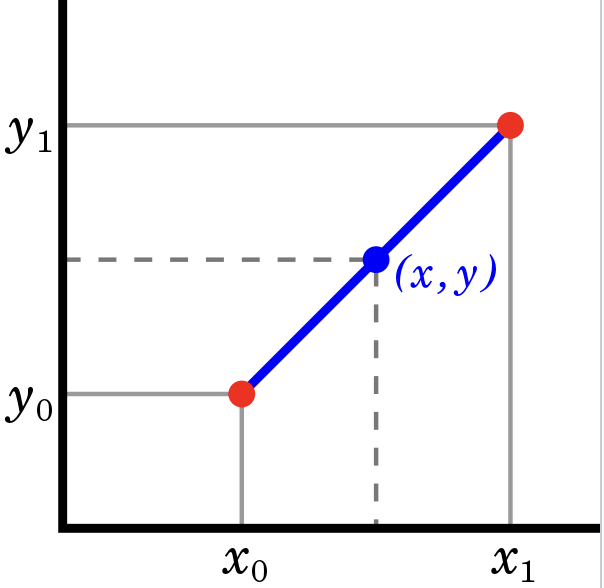

In [12]:
# 실제로 결측치라고 표시는 안되어있지만 아무 의미도 갖지 않는 element들이 아래와 같이 존재합니다.
# 아래 3가지의 경우 모두 아무 의미도 갖지 않는 element가 포함되어 있습니다.
display(concat['등기신청일자'].value_counts())

            1111271
20230630        585
20230831        496
20230428        394
20230731        374
             ...   
20230105          3
20230125          3
20230109          1
20230102          1
20230104          1
Name: 등기신청일자, Length: 182, dtype: int64

In [13]:
# 위 처럼 아무 의미도 갖지 않는 칼럼은 결측치와 같은 역할을 하므로, np.nan으로 채워 결측치로 인식되도록 합니다.
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

In [14]:
# EDA에 앞서 결측치를 확인해보겠습니다.
concat.isnull().sum()

시군구                             0
번지                            227
본번                             75
부번                             75
아파트명                         2136
전용면적                            0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1121899
등기신청일자                    1111271
거래유형                      1086451
중개사소재지                    1090013
k-단지분류(아파트,주상복합등등)         877273
k-전화번호                     876850
k-팩스번호                     879348
단지소개기존clob                1058958
k-세대타입(분양형태)               876125
k-관리방식                     876125
k-복도유형                     876454
k-난방방식                     876125
k-전체동수                     877207
k-전체세대수                    876125
k-건설사(시공사)                 877637
k-시행사                      877834
k-사용검사일-사용승인일              876259
k-연면적                      876125
k-주거전용면적      

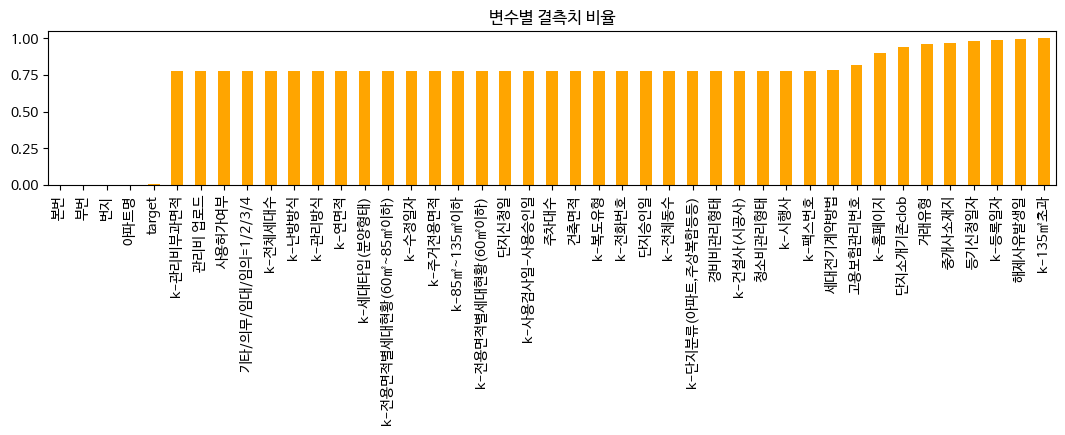

In [15]:
# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.
fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

In [16]:
concat['건축면적'].isnull().sum()

876279

- 위 그래프에서 볼 수 있다시피 결측치가 100만개 이상인 칼럼들은 결측치가 해당 칼럼의 element 중 90% 이상을 차지하는 상황이 됩니다.
- 따라서 본 Baseline 에서는 이 칼럼은 예측에 도움이 되지 않는다고 판단해 삭제해주도록 하겠습니다.

In [17]:
# Null값이 100만개 이상인 칼럼은 삭제해보도록 하겠습니다.
print('* 결측치가 100만개 이하인 변수들 :', list(concat.columns[concat.isnull().sum() <= 1000000]))     # 남겨질 변수들은 아래와 같습니다.
print('* 결측치가 100만개 이상인 변수들 :', list(concat.columns[concat.isnull().sum() >= 1000000]))

* 결측치가 100만개 이하인 변수들 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'is_test']
* 결측치가 100만개 이상인 변수들 : ['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', '단지소개기존clob', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자']


In [18]:
# 이후에 나올 코드에서 상당히 많은 피처를 drop할 것이기에 기존 코드는 주석처리했다

# 위에서 결측치가 100만개 이하인 변수들만 골라 새로운 concat_select 객체로 저장해줍니다.
# selected = list(concat.columns[concat.isnull().sum() <= 1000000])
# concat_select = concat[selected]

In [19]:
concat.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target', 'is_test'],
      dtype='object')

In [20]:
# concat['is_해제사유발생'] = concat['해제사유발생일'].notnull().astype(int)
# concat.drop('해제사유발생일', inplace=True, axis=1)

In [21]:
# concat['is_해제사유발생'].value_counts()

In [22]:
columns_to_drop = [
    '본번', '부번', '번지', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', '단지소개기존clob', 
    'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식','k-전체동수','k-전체세대수','k-건설사(시공사)',
    'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',  'k-전용면적별세대현황(60㎡이하)',
    'k-전용면적별세대현황(60㎡~85㎡이하)','k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자', 'k-수정일자', 
    '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4',
    '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일', '해제사유발생일'
]
concat_select = concat.drop(columns=columns_to_drop)

In [23]:
concat_select.isnull().sum()     # 결측치가 100만개 초과인 칼럼이 제거된 모습은 아래와 같습니다.
# target변수는 test dataset 개수만큼(9272) 결측치가 존재함을 확인할 수 있습니다.

시군구           0
아파트명       2136
전용면적          0
계약년월          0
계약일           0
층             0
건축년도          0
도로명           0
좌표X           0
좌표Y           0
target     9272
is_test       0
dtype: int64

In [24]:
# 연속형 변수는 선형보간을 해주고, 범주형변수는 알수없기에 “unknown”이라고 임의로 보간해 주겠습니다.
concat_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 12 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   시군구      1128094 non-null  object 
 1   아파트명     1125958 non-null  object 
 2   전용면적     1128094 non-null  float64
 3   계약년월     1128094 non-null  int64  
 4   계약일      1128094 non-null  int64  
 5   층        1128094 non-null  int64  
 6   건축년도     1128094 non-null  int64  
 7   도로명      1128094 non-null  object 
 8   좌표X      1128094 non-null  float64
 9   좌표Y      1128094 non-null  float64
 10  target   1118822 non-null  float64
 11  is_test  1128094 non-null  int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 111.9+ MB


In [25]:
# 본번 부번은 이전 코드에서 삭제했다

# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
# concat_select['본번'] = concat_select['본번'].astype('str')
# concat_select['부번'] = concat_select['부번'].astype('str')

In [26]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', '좌표X', '좌표Y', 'target', 'is_test']
범주형 변수: ['시군구', '아파트명', '도로명']


- 연속형 변수와 범주형 변수가 알맞게 나누어졌는지 확인해보고, 이제 각각 보간을 진행합니다.

In [27]:
# 범주형 변수에 대한 보간
concat_select[categorical_columns] = concat_select[categorical_columns].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
concat_select[continuous_columns] = concat_select[continuous_columns].interpolate(method='linear', axis=0)

In [28]:
concat_select.isnull().sum()         # 결측치가 보간된 모습을 확인해봅니다.

시군구        0
아파트명       0
전용면적       0
계약년월       0
계약일        0
층          0
건축년도       0
도로명        0
좌표X        0
좌표Y        0
target     0
is_test    0
dtype: int64

- Baseline에서는 단순 결측치들을 제거하거나 보간했지만,
EDA를 통해 변수들의 흐름을 조금 더 파악하고 더 나은 interpolation 등의 방법을 고려해볼 수 있을 것 같습니다.

### 3.2. 이상치 처리
- 이번엔 이상치를 처리해봅시다.
- 이상치를 처리하는 방법은 IQR, Z-score 등 다양한 방법이 있습니다. 가장 쉽고 직관적으로 접근하는 방법은 기본 통계치를 이용하는 것입니다.
- 본 baseline에서는 IQR를 이용한 방법을 사용하겠습니다.

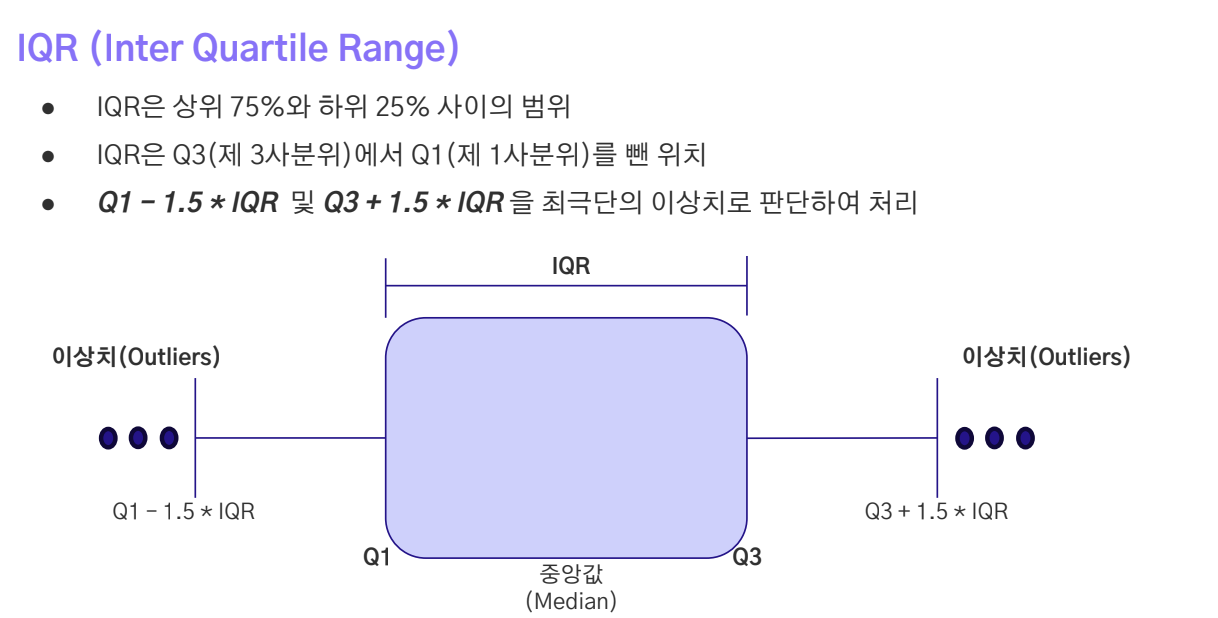

In [29]:
# 이상치 제거 이전의 shape은 아래와 같습니다.
print(concat_select.shape)

(1128094, 12)


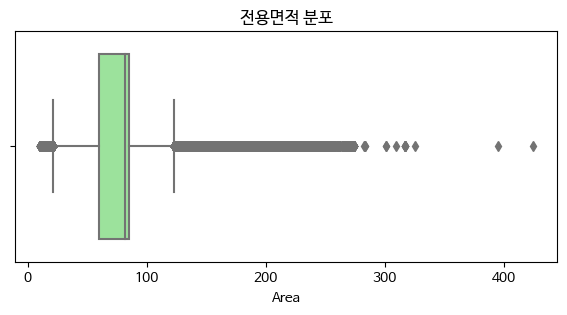

In [30]:
# 대표적인 연속형 변수인 “전용 면적” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = concat_select, x = '전용면적', color='lightgreen')
plt.title('전용면적 분포')
plt.xlabel('Area')
plt.show()

In [31]:
# 이상치 제거 방법에는 IQR을 이용하겠습니다.
def remove_outliers_iqr(dt, column_name):
    df = dt.query('is_test == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
    df_test = dt.query('is_test == 1')

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    result = pd.concat([df, df_test])   # test data와 다시 합쳐주겠습니다.
    return result

In [32]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
concat_select['구'] = concat_select['시군구'].map(lambda x : x.split()[1])
concat_select['동'] = concat_select['시군구'].map(lambda x : x.split()[2])
del concat_select['시군구']

concat_select['계약년'] = concat_select['계약년월'].astype('str').map(lambda x : x[:4])
concat_select['계약월'] = concat_select['계약년월'].astype('str').map(lambda x : x[4:])
del concat_select['계약년월']

In [33]:
# from sklearn.linear_model import LinearRegression

# def remove_time_linear_outliers_concat_select(
#     df,
#     group_col='아파트명',     # 어떤 기준으로 그룹핑(예: 아파트명)
#     year_col='계약년',        # 연도 컬럼명
#     month_col='계약월',       # 월 컬럼명
#     target_col='target',      # 거래가격(종속변수) 컬럼명
#     z_thresh=3.0
# ):
#     df['계약년'] = df['계약년'].astype(int)
#     df['계약월'] = df['계약월'].astype(int)
#     # -------------------------------------------------------------------
#     # 1) numeric_time 파생변수 생성: (연도 + (월-1)/12)
#     # -------------------------------------------------------------------
#     df = df.copy()  # 원본 보호 (사본 사용 권장)
#     df['numeric_time'] = df[year_col] + (df[month_col] - 1)/12.0

#     # -------------------------------------------------------------------
#     # 2) train/test 분리
#     # -------------------------------------------------------------------
#     df_train = df[df['is_test'] == 0].copy()  # 학습용
#     df_test  = df[df['is_test'] == 1].copy()  # 테스트용 (그대로 유지)

#     # -------------------------------------------------------------------
#     # 3) 학습용 데이터에서만 "시간 vs. 가격" 선형회귀 기반 이상치 제거
#     # -------------------------------------------------------------------
#     def remove_time_linear_outliers(train_df):
#         filtered_list = []

#         for group_val, sub_df in train_df.groupby(group_col):
#             # 아파트별로 묶어서 처리 (예: '아파트명')
#             # 데이터가 너무 적으면 그대로 통과
#             if len(sub_df) < 3:
#                 filtered_list.append(sub_df)
#                 continue
            
#             X = sub_df[['numeric_time']].values
#             y = sub_df[target_col].values

#             # 선형회귀
#             model = LinearRegression()
#             model.fit(X, y)

#             # 예측값, 잔차
#             y_pred = model.predict(X)
#             residuals = y - y_pred
#             std_res = residuals.std()

#             # 표준편차가 0이면(데이터가 동일) -> 이상치 판단 불가 -> 그대로
#             if std_res == 0:
#                 filtered_list.append(sub_df)
#                 continue

#             # 잔차 임계값: ±(z_thresh * 표준편차)
#             lower_bound = -z_thresh * std_res
#             upper_bound =  z_thresh * std_res

#             # 잔차가 임계 범위 내인 거래만 채택
#             condition = (residuals >= lower_bound) & (residuals <= upper_bound)
#             filtered_sub_df = sub_df[condition].copy()

#             filtered_list.append(filtered_sub_df)

#         # 그룹별로 필터링한 결과 합치기
#         new_df = pd.concat(filtered_list, axis=0).reset_index(drop=True)
#         return new_df

#     # 실제 이상치 제거 수행
#     df_train_filtered = remove_time_linear_outliers(df_train)

#     # -------------------------------------------------------------------
#     # 4) 제거한 학습용 + 원본 테스트용 = 최종 합치기
#     # -------------------------------------------------------------------
#     df_final = pd.concat([df_train_filtered, df_test], axis=0).reset_index(drop=True)
#     del df_final['numeric_time']
#     return df_final

In [34]:
# # (1) 함수 호출
# df_after = remove_time_linear_outliers_concat_select(
#     df=concat_select,
#     group_col='아파트명',
#     year_col='계약년',
#     month_col='계약월',
#     target_col='target',
#     z_thresh=3.0
# )

# # (2) 결과 확인
# print("처리 전 데이터 크기:", concat_select.shape)
# print("처리 후 데이터 크기:", df_after.shape)

# concat_select = df_after
# concat_select['계약년'] = concat_select['계약년'].astype('str')
# concat_select['계약월'] = concat_select['계약월'].astype('str')

# # (3) 이제 df_after를 기반으로 모델링(학습) 진행하면 됨

In [35]:
# 해당 코드의 이상치 제거는 성능에 심각한 악영향을 끼친다.
# 상당한 정상 데이터도 같이 삭제하기 때문인걸로 추측측

# 위 방법으로 전용 면적에 대한 이상치를 제거해보겠습니다.
# concat_select = remove_outliers_iqr(concat_select, '전용면적')

In [36]:
# concat_select['계약년'].min()

In [37]:
# 계약연월이 2015년 이전 거래인 것은 이상치로 판단
# concat_select = concat_select[concat_select['계약년'].astype('int') > 2010]


In [38]:
# 이상치 제거 후의 shape은 아래와 같습니다. 약 10만개의 데이터가 제거된 모습을 확인할 수 있습니다.
print(concat_select.shape)

(1128094, 14)


In [39]:
concat_select['is_test'].value_counts()     # 또한, train data만 제거되었습니다.

0    1118822
1       9272
Name: is_test, dtype: int64

## 4. Feature Engineering
- 이제 파생변수를 만들어보도록 하겠습니다.
- 파생 변수는 도메인 지식에 기반해 제작하는 것이 중요합니다.
- 주택의 가격을 예측하는 문제이기 때문에 약간의 부동산 지식을 기반으로 파생 변수를 만들어 보도록 하겠습니다.

In [40]:
concat_select.shape

(1128094, 14)

In [41]:
# # 같은 아파트와 같은 전용면적인 아파트에서 target의 하위 이상치 제거거
# # RMSE도 떨어지고 꽤 괜찮다고 생각하는데, 왜 제출만하면 점수가 높아지지지
# # 이후에 다시 연구가 필요하다. 상당한 정상 데이터를 삭제하기 때문인걸로 생각됨. 확실히 이상치인것만 삭제해야한다다

# def remove_outliers_by_group_target(df_origin):
#     # is_test가 0인 데이터와 1인 데이터를 분리
#     df = df_origin.query('is_test == 0')  # is_test == 0인 데이터만
#     df_test = df_origin.query('is_test == 1')  # is_test == 1인 데이터는 그대로 둠
    
#     # 같은 아파트명, 좌표X, 좌표Y, 계약년을 기준으로 그룹화
#     grouped = df.groupby(['아파트명', '좌표X', '좌표Y', '전용면적'])
    
#     # 조건에 맞는 행 제거
#     to_remove = []
#     for (apartment, x, y, meter), group in grouped:
#         Q1 = group['target'].quantile(0.25)
#         Q3 = group['target'].quantile(0.75)
#         IQR = Q3 - Q1

#         lower_bound = Q1 - 1.5 * IQR
#         # upper_bound = Q3 + 1.5 * IQR

#         outliers = group[group['target'] < lower_bound]
        
#         if len(outliers) == 1:
#             print(f"제거 대상: 아파트명={apartment}, 전용면적={meter}")
#             # outliers에서 제거할 인덱스를 저장
#             to_remove.extend(outliers.index)
    
#     # is_test == 0인 데이터에서 이상치만 제거
#     df_cleaned = df.drop(to_remove)
    
#     # 최종적으로 is_test == 1인 데이터와 합침
#     result = pd.concat([df_cleaned, df_test])
    
#     return result

# # 함수 실행
# concat_select = remove_outliers_by_group_target(concat_select)

# # 확인
# concat_select['is_test'].value_counts()

In [42]:
# 같은아파트에서 하위 전용면적 이상치 제거
# 0.004는 이상치가 맞음 예외없이 이상한 데이터들임임
# 0.008까지 설정해야할듯 0.009부턴 선릉역대우아이빌의 데이터가가 정상인거같음

def remove_outliers_by_group_meter(df_origin):
    # is_test가 0인 데이터와 1인 데이터를 분리
    df = df_origin.query('is_test == 0')  # is_test == 0인 데이터만
    df_test = df_origin.query('is_test == 1')  # is_test == 1인 데이터는 그대로 둠
    
    # 같은 아파트명, 좌표X, 좌표Y, 계약년을 기준으로 그룹화
    grouped = df.groupby(['아파트명', '좌표X', '좌표Y'])
    
    # 조건에 맞는 행 제거
    to_remove = []
    for (apartment, x, y), group in grouped:
        Q1 = group['전용면적'].quantile(0.25)
        Q3 = group['전용면적'].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = group[group['전용면적'] < lower_bound]
        
        outlier_ratio = len(outliers) / len(group)

        # 비율이 8% 이하일 때만 제거
        if 0 < outlier_ratio <= 0.008 and len(outliers) == 1:
            print(f"outlier: {len(outliers)} / group: {len(group)}  = {outlier_ratio}, 아파트: {apartment}")
            to_remove.extend(outliers.index)
    
    # is_test == 0인 데이터에서 이상치만 제거
    df_cleaned = df.drop(to_remove)
    print(df_cleaned.shape)
    # 최종적으로 is_test == 1인 데이터와 합침
    result = pd.concat([df_cleaned, df_test])
    # 아래 코드는 테스트용
    # result = pd.concat([df, df_test])
    return result

# 함수 실행
concat_select = remove_outliers_by_group_meter(concat_select)

# 확인
concat_select['is_test'].value_counts()

outlier: 1 / group: 334  = 0.0029940119760479044, 아파트: 극동그린
outlier: 1 / group: 307  = 0.003257328990228013, 아파트: 상림마을6단지푸르지오BL1-7
outlier: 1 / group: 185  = 0.005405405405405406, 아파트: 천왕이펜하우스1단지
outlier: 1 / group: 143  = 0.006993006993006993, 아파트: 천왕이펜하우스6단지
outlier: 1 / group: 637  = 0.0015698587127158557, 아파트: 코오롱
outlier: 1 / group: 173  = 0.005780346820809248, 아파트: 한양5
(1118816, 14)


0    1118816
1       9272
Name: is_test, dtype: int64

In [43]:
# temp[temp['전용면적'] == 20.37]
# # temp
# temp[(temp['계약년'] == '2022')]
# # temp[(temp['계약년'] == '2009') & (temp['동'] == '압구정동')]

In [44]:
# outlier 제거 코드 원본
# def remove_outliers_by_group(df_origin):
#     # is_test가 0인 데이터와 1인 데이터를 분리
#     df = df_origin.query('is_test == 0')  # is_test == 0인 데이터만
#     df_test = df_origin.query('is_test == 1')  # is_test == 1인 데이터는 그대로 둠
    
#     # 같은 아파트명, 좌표X, 좌표Y, 계약년을 기준으로 그룹화
#     grouped = df.groupby(['아파트명', '좌표X', '좌표Y', '계약년'])
    
#     # 조건에 맞는 행 제거
#     to_remove = []
#     for _, group in grouped:
#         # 그룹 내 target의 상위 1%와 하위 1% 값을 구합니다.
#         upper_5_percent = group['target'].quantile(0.99)
#         lower_5_percent = group['target'].quantile(0.01)
        
#         # is_test가 0인 데이터에서 target값이 상위 5% 또는 하위 5%인 데이터를 찾습니다.
#         outliers = group[(group['target'] > upper_5_percent) | (group['target'] < lower_5_percent)]
        
#         # outliers에서 제거할 인덱스를 저장
#         to_remove.extend(outliers.index)
    
#     # is_test == 0인 데이터에서 이상치만 제거
#     df_cleaned = df.drop(to_remove)
    
#     # 최종적으로 is_test == 1인 데이터와 합침
#     result = pd.concat([df_cleaned, df_test])
    
#     return result

# # 함수 실행
# concat_select = remove_outliers_by_group(concat_select)

# # 확인
# concat_select['is_test'].value_counts()

- 서울의 집값은 강남, 강북 여부에 따라 차이가 많이 난다는 사실은 많이 알려진 사실입니다.
- 따라서 강남/강북의 여부에 따라 파생변수를 생성해주도록 하겠습니다.

In [45]:
# all = list(concat_select['구'].unique())
# gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
# gangbuk = [x for x in all if x not in gangnam]

# assert len(all) == len(gangnam) + len(gangbuk)       # 알맞게 분리되었는지 체크합니다.

In [46]:
# # 강남의 여부를 체크합니다.
# is_gangnam = []
# for x in concat_select['구'].tolist() :
#   if x in gangnam :
#     is_gangnam.append(1)
#   else :
#     is_gangnam.append(0)

# # 파생변수를 하나 만릅니다.
# # concat_select['강남여부'] = is_gangnam

In [47]:
concat_select.columns

Index(['아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', '좌표X', '좌표Y', 'target',
       'is_test', '구', '동', '계약년', '계약월'],
      dtype='object')

- 또한 신축인지, 구축인지의 여부도 실거래가에 큰 영향을 줄 수 있습니다.
- 따라서 건축년도에 따라 파생변수를 제작해주도록 하겠습니다.

In [48]:
# # 건축년도 분포는 아래와 같습니다. 특히 2005년이 Q3에 해당합니다.
# # 2009년 이후에 지어진 건물은 10%정도 되는 것을 확인할 수 있습니다.
# concat_select['건축년도'].describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.8, 0.9])

In [49]:
# 따라서 2009년 이후에 지어졌으면 비교적 신축이라고 판단하고, 신축 여부 변수를 제작해보도록 하겠습니다.
# concat_select['신축여부'] = concat_select['건축년도'].apply(lambda x: 1 if x >= 2017 else 0)

In [50]:
# concat_select.head(1)       # 최종 데이터셋은 아래와 같습니다.

In [51]:
# concat_select.shape

- 위 두 사항 외에도 외부 공공 데이터를 이용하거나, EDA를 통해 더 많은 변수를 제작할 수 있습니다.

In [52]:
subway = pd.read_csv('/data/ephemeral/home/data/subway_feature.csv')
bus = pd.read_csv('/data/ephemeral/home/data/bus_feature.csv')

In [53]:
subway.head()

,역사_ID,역사명,호선,위도,경도
0,9996,미사,5호선,37.560927,127.193877
1,9995,강일,5호선,37.557490,127.175930
2,4929,김포공항,김포골드라인,37.562360,126.801868
3,4928,고촌,김포골드라인,37.601243,126.770345
4,4927,풍무,김포골드라인,37.612488,126.732387


In [54]:
bus.shape

(12584, 6)

In [55]:
# # 역세권 판단. 너무 오래걸린다
# from geopy.distance import geodesic

# # 1. 대표 좌표 추출
# unique_coords = concat_select[['좌표X', '좌표Y']].drop_duplicates().reset_index(drop=True)

# # 2. 각 아파트 단지와 지하철 역 간의 거리 계산
# def calculate_near_subway(apartment_coords):
#     nearest_subway_name = None
#     nearest_subway_coords = None
#     min_distance = float('inf')  # 초기값을 무한대로 설정
#     for subway_coords in subway[['위도', '경도']].to_numpy():
#         distance = geodesic(apartment_coords, subway_coords).meters
#         min_distance = min(min_distance, distance)
        
#         if distance < min_distance:
#             min_distance = distance
#             nearest_subway_name = subway_row['역명']
#             nearest_subway_coords = subway_coords

#     print(f"아파트 좌표: {apartment_coords} ➡️ 가장 가까운 지하철역: {nearest_subway_name} "
#         f"({nearest_subway_coords}), 거리: {min_distance:.2f}미터")
        
#     return min_distance

# # 3. 500m 이내를 역세권으로 표시
# unique_coords['is_near_subway'] = unique_coords.apply(
#     lambda row: 1 if calculate_near_subway((row['좌표Y'], row['좌표X'])) <= 500 else 0,
#     axis=1
# )

# # 4. 원래 데이터로 거리 값 매핑
# concat_select = pd.merge(
#     concat_select,
#     unique_coords[['좌표X', '좌표Y', 'is_near_subway']],
#     on=['좌표X', '좌표Y'],
#     how='left'
# )

In [56]:
# concat_select['is_near_subway'].value_counts()

In [57]:
# unique_coords = concat_select[['좌표X', '좌표Y']].drop_duplicates().reset_index(drop=True)

In [58]:
# # is_near_subway만 썼을때가 제일 잘됐다
# from scipy.spatial import KDTree

# # 1. 대표 좌표 추출
# unique_coords = concat_select[['좌표X', '좌표Y']].drop_duplicates().reset_index(drop=True)

# # 2. KDTree 생성
# subway_tree = KDTree(subway[['경도', '위도']].to_numpy())

# # 대표 좌표 배열
# unique_coords_array = unique_coords[['좌표X', '좌표Y']].to_numpy()

# # 3. 각 아파트 단지에서 500m 이내의 지하철역 수와 가장 가까운 지하철역 거리 계산
# def get_subway_info(coords, tree, radius=0.005):
#     # 반경 내 지하철역 정보
#     nearby_indices = tree.query_ball_point(coords, radius)
    
#     # 지하철 역 이름과 호선 정보 추출
#     nearby_stations = subway.iloc[nearby_indices]
#     unique_stations = nearby_stations['역사명'].unique()
#     line_count = nearby_stations['호선'].nunique()  # 고유한 호선의 개수

#     # 가장 가까운 지하철역 거리 계산
#     min_distance, _ = tree.query(coords)
#     min_distance_meters = min_distance * 111000  # 도 단위 -> 미터 변환

#     return len(unique_stations), line_count, min_distance_meters  # 역의 개수를 반환

# # 4. 역 이름의 갯수, 호선 개수, 거리 계산
# subway_info = [get_subway_info(coords, subway_tree) for coords in unique_coords_array]
# unique_coords['subway_count_within_500m'], unique_coords['subway_line_count_within_500m'], unique_coords['min_subway_distance'] = zip(*subway_info)

# # 5. 원래 데이터로 매핑 (is_near_subway 피처는 제외)
# concat_select = pd.merge(
#     concat_select,
#     unique_coords[['좌표X', '좌표Y', 'min_subway_distance', 'subway_count_within_500m', 'subway_line_count_within_500m']],
#     on=['좌표X', '좌표Y'],
#     how='left'
# )

In [59]:
# # 역세권 원본
# # 역세권 여부 판단
# # 역세권 판단 코드중 아직까진 이게 제일 성능이 좋음
# from scipy.spatial import KDTree

# # 1. 대표 좌표 추출
# unique_coords = concat_select[['좌표X', '좌표Y']].drop_duplicates().reset_index(drop=True)

# # 2. KDTree 생성 및 거리 계산
# # 지하철 거리 및 역세권 판단
# subway_tree = KDTree(subway[['경도', '위도']].to_numpy())

# # 대표 좌표에서 최근접 지하철 거리 계산
# unique_coords_array = unique_coords[['좌표X', '좌표Y']].to_numpy()
# subway_distances, _ = subway_tree.query(unique_coords_array)

# # 500m 이내를 역세권으로 표시
# unique_coords['is_near_subway'] = (subway_distances <= 0.005).astype(int)

# # 3. 원래 데이터로 거리 값 매핑
# concat_select = pd.merge(
#     concat_select,
#     unique_coords[['좌표X', '좌표Y', 'is_near_subway']],
#     on=['좌표X', '좌표Y'],
#     how='left'
# )

In [60]:
# concat_select['계약년'].astype('int').min()

In [61]:
# concat_select['is_near_subway'].value_counts()

In [62]:
# # 특정 동 리스트 설정
# # dong = ['한남동', '청담동']

# dong = [
#     '한남동', '청담동', '압구정동', '서초동', '방배동', '신사동', '삼성동',
#     '잠원동', '논현동', '도곡동', '개포동', '잠실동', '반포동', '일원동',
#     '잠실본동', '내곡동', '염곡동', '우면동', '신천동'
# ]
# # 'is_high_price_area'라는 새로운 피처 추가
# concat_select['is_high_price_area'] = concat_select['동'].apply(lambda x: 1 if x in dong else 0)

# # 결과 확인
# concat_select.head()

대장 아파트 피처

In [63]:
# # 지역구별 대장 아파트들을 입력합니다.
# lead_house = {
#     "강서구" : (37.56520754904415, 126.82349451366355),
#     "관악구" : (37.47800896704934, 126.94178722423047),
#     "강남구" : (37.530594054209146, 127.0262701317293),
#     "강동구" : (37.557175745977375, 127.16359581113558),
#     "광진구" : (37.543083184171, 127.0998363490422),
#     "구로구" : (37.51045944660659, 126.88687199829572),
#     "금천구" : (37.459818907487936, 126.89741481874103),
#     "노원구" : (37.63952738902813, 127.07234254197617),
#     "도봉구" : (37.65775043994647, 127.04345013224447),
#     "동대문구" : (37.57760781415707, 127.05375628992316),
#     "동작구" : (37.509881249641495, 126.9618159122961),
#     "마포구" : (37.54341664563958, 126.93601641235335),
#     "서대문구" : (37.55808950436837, 126.9559315685538),
#     "서초구" : (37.50625410912666, 126.99846468032919),
#     "성동구" : (37.53870643389788, 127.04496220606433),
#     "성북구" : (37.61158435092128, 127.02699796439015),
#     "송파구" : (37.512817775046074, 127.08340371063358),
#     "양천구" : (37.526754982736556, 126.86618704123521),
#     "영등포구" : (37.52071403351804, 126.93668907644046),
#     "용산구" : (37.521223570097305, 126.97345317787784),
#     "은평구" : (37.60181702377437, 126.9362806808709),
#     "종로구" : (37.56856915384472, 126.96687674967252),
#     "중구" : (37.5544678205846, 126.9634879236162),
#     "중랑구" : (37.58171824083332, 127.08183326205129),
#     "강북구" : (37.61186335979484, 127.02822407466175)
# }

In [64]:
import math
# 위경도를 이용해 두 지점간의 거리를 구하는 함수를 생성합니다.
def haversine_distance(lat1, lon1, lat2, lon2):
    radius = 6371.0

    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = radius * c
    return distance

In [65]:
# # 대장 아파트의 위경도 데이터프레임을 구성합니다.
# lead_house_data = pd.DataFrame([{"구": k, "대장_좌표X": v[1], "대장_좌표Y": v[0]} for k, v in lead_house.items()])
# # 데이터프레임간 결합을 합니다.
# concat_select = pd.merge(concat_select, lead_house_data, how="inner", on="구")
# # 아까 제작한 haversine_distance 함수를 이용해 대장아파트와의 거리를 계산하고, 새롭게 컬럼을 구성합니다.
# concat_select['대장아파트_거리'] = concat_select.apply(lambda row: haversine_distance(row["좌표Y"], row["좌표X"], row["대장_좌표Y"], row["대장_좌표X"]), axis=1)

In [66]:
avg_price_by_dong = concat_select.groupby(['구', '동'])['target'].mean().reset_index()
avg_price_by_dong.rename(columns={'target': 'avg_price_by_dong'}, inplace=True)

# 2. concat_select에 동별 평균가격 피처 추가
concat_select = pd.merge(
    concat_select,
    avg_price_by_dong[['구', '동', 'avg_price_by_dong']],
    on=['구', '동'],
    how='left'
)

In [67]:
concat_select.columns

Index(['아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', '좌표X', '좌표Y', 'target',
       'is_test', '구', '동', '계약년', '계약월', 'avg_price_by_dong'],
      dtype='object')

In [68]:
# # 계약년 문자열을 정수로 변환
# concat_select['계약년'] = concat_select['계약년'].astype(int)

# # 2018년 이후 데이터 필터링
# data_after_2018 = concat_select[concat_select['계약년'] >= 2018]

# # 동별 평균 target 계산 (2018년 이후)
# avg_price_after_2018= (
#     data_after_2018.groupby(['구', '동'])['target']
#     .mean()
#     .reset_index()
#     .rename(columns={'target': 'avg_price_by_dong'})
# )

# # 원래 데이터프레임에 매핑하여 파생변수 추가
# concat_select = pd.merge(
#     concat_select,
#     avg_price_after_2018,
#     on=['구', '동'],
#     how='left'
# )

# # 결과 확인
# print(concat_select[['구', '동', 'avg_price_by_dong']].head())

In [69]:
concat_select.head()

,아파트명,전용면적,계약일,층,건축년도,도로명,좌표X,좌표Y,target,is_test,구,동,계약년,계약월,avg_price_by_dong
0,개포6차우성,79.97,8,3,1987,언주로 3,127.05721,37.476763,124000.0,0,강남구,개포동,2017,12,92107.125518
1,개포6차우성,79.97,22,4,1987,언주로 3,127.05721,37.476763,123500.0,0,강남구,개포동,2017,12,92107.125518
2,개포6차우성,54.98,28,5,1987,언주로 3,127.05721,37.476763,91500.0,0,강남구,개포동,2017,12,92107.125518
3,개포6차우성,79.97,3,4,1987,언주로 3,127.05721,37.476763,130000.0,0,강남구,개포동,2018,01,92107.125518
4,개포6차우성,79.97,8,2,1987,언주로 3,127.05721,37.476763,117000.0,0,강남구,개포동,2018,01,92107.125518


In [70]:
# 구별 평균가격은 동별에 비해 성능이 떨어짐

# mean_price_by_gu = concat_select.groupby('구')['target'].mean().sort_values()

In [71]:
# mean_price_by_gu = concat_select.groupby('구')['target'].mean().sort_values(ascending=False)

# # 시각화
# plt.figure(figsize=(12, 8))
# sns.barplot(x=mean_price_by_gu.values, y=mean_price_by_gu.index, palette='viridis')
# plt.title('Average Apartment Price by District (구)', fontsize=16)
# plt.xlabel('Average Price', fontsize=14)
# plt.ylabel('District (구)', fontsize=14)
# plt.show()

In [72]:
# #도로명에서 도로명만 남김

# # 문자열로 변환 후 split 적용
# concat_select['도로명'] = concat_select['도로명'].astype(str).map(lambda x: x.split()[0] if isinstance(x, str) and len(x.split()) > 0 else x)
# concat_select['도로명']

In [73]:
# # 평균 집값 데이터 가져오기

# # 1. 평균 매매 데이터 불러오기
# average_price_path = "/data/ephemeral/home/data/(월) 평균매매가격_아파트.csv"  # 파일 경로를 설정
# average_price = pd.read_csv(average_price_path)

# # 자료시점에서 결측치 제거
# average_price = average_price.dropna(subset=['자료시점'])

# # 자료시점에서 '년', '월' 제거 및 공백 제거 후 분리
# average_price['계약년'] = average_price['자료시점'].str.replace('년', '').str.replace('월', '').str.strip().str.split().str[0].astype(int)
# average_price['계약월'] = average_price['자료시점'].str.replace('년', '').str.replace('월', '').str.strip().str.split().str[1].astype(int)

# # Tidy 형태로 변환
# average_price_melted = average_price.melt(
#     id_vars=['계약년', '계약월'], 
#     var_name='구', 
#     value_name='평균매매가격'
# )

# # concat_select의 계약년, 계약월, 구 컬럼 데이터 유형 변환
# concat_select['계약년'] = concat_select['계약년'].astype(int)
# concat_select['계약월'] = concat_select['계약월'].astype(int)
# concat_select['구'] = concat_select['구'].astype(str)

# # average_price_melted의 구 데이터 유형 변환
# average_price_melted['구'] = average_price_melted['구'].astype(str)

# # concat_select 데이터와 평균 매매 가격 데이터 병합
# concat_select = pd.merge(
#     concat_select, 
#     average_price_melted, 
#     on=['구', '계약년', '계약월'], 
#     how='left'
# )

# concat_select['평균매매가격'] = concat_select['평균매매가격'].astype('float')

# # 결과 확인
# print(concat_select[['구', '계약년', '계약월', '평균매매가격']].head())

In [74]:
# concat_select[concat_select['is_test'] == 0]['전용면적'].min()

In [75]:
# concat_select[concat_select['전용면적'] == 10.02]

In [76]:
# # 전용면적을 기준으로 소형, 중형, 대형, 초대형 구간화
# def categorize_area(area):
#     if area < 33:
#         return '10평 이하'
#     elif 33 <= area < 49:
#         return '10평 초'
#     elif 49 <= area < 66:
#         return '10평 후'
#     elif 66 <= area < 82.5:
#         return '20평 초'
#     elif 82.5 <= area < 99:
#         return '20평 후'
#     elif 99 <= area < 115.5:
#         return '30평 초'
#     elif 115.5 <= area < 132:
#         return '30평 후'
#     elif 132 <= area < 148.5:
#         return '40평 초'
#     elif 148.5 <= area < 165:
#         return '40평 후'
#     elif 165 <= area < 198:
#         return '50평 대'
#     elif 198 <= area < 231:
#         return '60평 대'
#     elif 231 <= area < 264:
#         return '70평 대'
#     else : 
#         return '80평 이상'


# # concat_select에 새로운 파생변수 '전용면적_구간' 추가
# concat_select['전용면적_구간'] = concat_select['전용면적'].apply(categorize_area)

# # 결과 확인
# print(concat_select[['전용면적', '전용면적_구간']].head())

In [77]:
# # 금리 칼럼 추가
# rate_data = [
#     {'변경일자': '2024-11-28', '기준금리': 3.00}, {'변경일자': '2024-10-11', '기준금리': 3.25},
#     {'변경일자': '2023-01-13', '기준금리': 3.50}, {'변경일자': '2022-11-24', '기준금리': 3.25},
#     {'변경일자': '2022-10-12', '기준금리': 3.00}, {'변경일자': '2022-08-25', '기준금리': 2.50},
#     {'변경일자': '2022-07-13', '기준금리': 2.25}, {'변경일자': '2022-05-26', '기준금리': 1.75},
#     {'변경일자': '2022-04-14', '기준금리': 1.50}, {'변경일자': '2022-01-14', '기준금리': 1.25},
#     {'변경일자': '2021-11-25', '기준금리': 1.00}, {'변경일자': '2021-08-26', '기준금리': 0.75},
#     {'변경일자': '2020-05-28', '기준금리': 0.50}, {'변경일자': '2020-03-17', '기준금리': 0.75},
#     {'변경일자': '2019-10-16', '기준금리': 1.25}, {'변경일자': '2019-07-18', '기준금리': 1.50},
#     {'변경일자': '2018-11-30', '기준금리': 1.75}, {'변경일자': '2017-11-30', '기준금리': 1.50},
#     {'변경일자': '2016-06-09', '기준금리': 1.25}, {'변경일자': '2015-06-11', '기준금리': 1.50},
#     {'변경일자': '2015-03-12', '기준금리': 1.75}, {'변경일자': '2014-10-15', '기준금리': 2.00},
#     {'변경일자': '2014-08-14', '기준금리': 2.25}, {'변경일자': '2013-05-09', '기준금리': 2.50},
#     {'변경일자': '2012-10-11', '기준금리': 2.75}, {'변경일자': '2012-07-12', '기준금리': 3.00},
#     {'변경일자': '2011-06-10', '기준금리': 3.25}, {'변경일자': '2011-03-10', '기준금리': 3.00},
#     {'변경일자': '2011-01-13', '기준금리': 2.75}, {'변경일자': '2010-11-16', '기준금리': 2.50},
#     {'변경일자': '2010-07-09', '기준금리': 2.25}, {'변경일자': '2009-02-12', '기준금리': 2.00},
#     {'변경일자': '2009-01-09', '기준금리': 2.50}, {'변경일자': '2008-12-11', '기준금리': 3.00},
#     {'변경일자': '2008-11-07', '기준금리': 4.00}, {'변경일자': '2008-10-27', '기준금리': 4.25},
#     {'변경일자': '2008-10-09', '기준금리': 5.00}, {'변경일자': '2008-08-07', '기준금리': 5.25},
#     {'변경일자': '2007-08-09', '기준금리': 5.00}, {'변경일자': '2007-07-12', '기준금리': 4.75},
#     {'변경일자': '2006-08-10', '기준금리': 4.50}, {'변경일자': '2006-06-08', '기준금리': 4.25},
#     {'변경일자': '2006-02-09', '기준금리': 4.00}, {'변경일자': '2005-12-08', '기준금리': 3.75},
#     {'변경일자': '2005-10-11', '기준금리': 3.50}, {'변경일자': '2004-11-11', '기준금리': 3.25},
#     {'변경일자': '2004-08-12', '기준금리': 3.50}, {'변경일자': '2003-07-10', '기준금리': 3.75},
#     {'변경일자': '2003-05-13', '기준금리': 4.00}, {'변경일자': '2002-05-07', '기준금리': 4.25},
#     {'변경일자': '2001-09-19', '기준금리': 4.00}, {'변경일자': '2001-08-09', '기준금리': 4.50},
#     {'변경일자': '2001-07-05', '기준금리': 4.75}, {'변경일자': '2001-02-08', '기준금리': 5.00},
#     {'변경일자': '2000-10-05', '기준금리': 5.25}, {'변경일자': '2000-02-10', '기준금리': 5.00},
#     {'변경일자': '1999-05-06', '기준금리': 4.75},
# ]

# # 금리 데이터프레임 생성
# rate_df = pd.DataFrame(rate_data)
# rate_df['변경일자'] = pd.to_datetime(rate_df['변경일자'])

# # 계약일자 생성
# concat_select['계약일자'] = pd.to_datetime(
#     concat_select['계약년'].astype(str) + '-' +
#     concat_select['계약월'].astype(str) + '-' +
#     concat_select['계약일'].astype(str)
# )

# # 금리 매핑 함수
# def find_rate_no_sort(date, rate_list):
#     for rate in rate_list:
#         if rate['변경일자'] <= date:
#             return rate['기준금리']
#     return rate_list[-1]['기준금리']  # 모든 날짜보다 과거일 경우 가장 오래된 금리 반환

# # 금리 매핑 (정렬 없이 처리)
# rate_list = rate_df.to_dict('records')  # 데이터프레임을 리스트로 변환
# concat_select['기준금리'] = concat_select['계약일자'].apply(lambda x: find_rate_no_sort(x, rate_list))

# # 계약일자 삭제
# del concat_select['계약일자']

# # 결과 확인
# print(concat_select[['기준금리']])

In [78]:
del concat_select['좌표X']
del concat_select['좌표Y']
del concat_select['계약일']
# del concat_select['계약월']

In [79]:
#전용면적, target 로그
concat_select['전용면적'] = np.log1p(concat_select['전용면적'])  # log1p 사용(log(1 + x) 형태)
# concat_select['avg_price_by_dong'] = np.log1p(concat_select['avg_price_by_dong'])  # log1p 사용(log(1 + x) 형태)
concat_select['target'] = np.log1p(concat_select['target'])  # log1p 사용(log(1 + x) 형태)

In [80]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# concat_select['avg_price_by_dong'] = scaler.fit_transform(concat_select[['avg_price_by_dong']])

## 5. Model Training

- 이제 위에서 만든 파생변수들과 정제한 데이터를 기반으로 본격적으로 부동산 실거래가를 예측하는 모델링을 진행하겠습니다.
- 모델링에는 `sklearn`의 `RandomForest`를 이용하도록 하겠습니다.

- 참고 ✅
  - `RandomForest`는 배깅(Bagging)의 일종으로, 학습시키는 데이터 뿐 아니라 특성변수(X)들도 무작위로 선택해 트리를 생성하는 방법입니다.
  - 모델 학습 과정에서 서로 다른 N개의 Tree 생성하고, N개의 Tree에서 발생한 Output을 Voting(범주형, 분류문제)하거나, Average(연속형, 회귀문제)해 최종 Output 생성합니다.
  - 이는 High variance, Low bias 상황에서 분산(Variance) 감소에 도움을 줍니다.

In [81]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_select.query('is_test==0')
dt_test = concat_select.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1118816, 11) (9272, 11)


In [82]:
dt_test.head(1)

,아파트명,전용면적,층,건축년도,도로명,target,구,동,계약년,계약월,avg_price_by_dong
1118816,개포6차우성,4.394079,5,1987,언주로 3,9.491828,강남구,개포동,2023,07,92107.125518


In [83]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

### 5.1. 범주형 변수 Encoding
- 범주형 변수는 그대로 모델에 투입하면, 모델이 제대로 작동할 수 없습니다.
- 따라서 **레이블 인코딩 과정**을 통해 범주형 변수들을 numeric하게 바꾸는 인코딩 과정을 진행해주도록 하겠습니다.

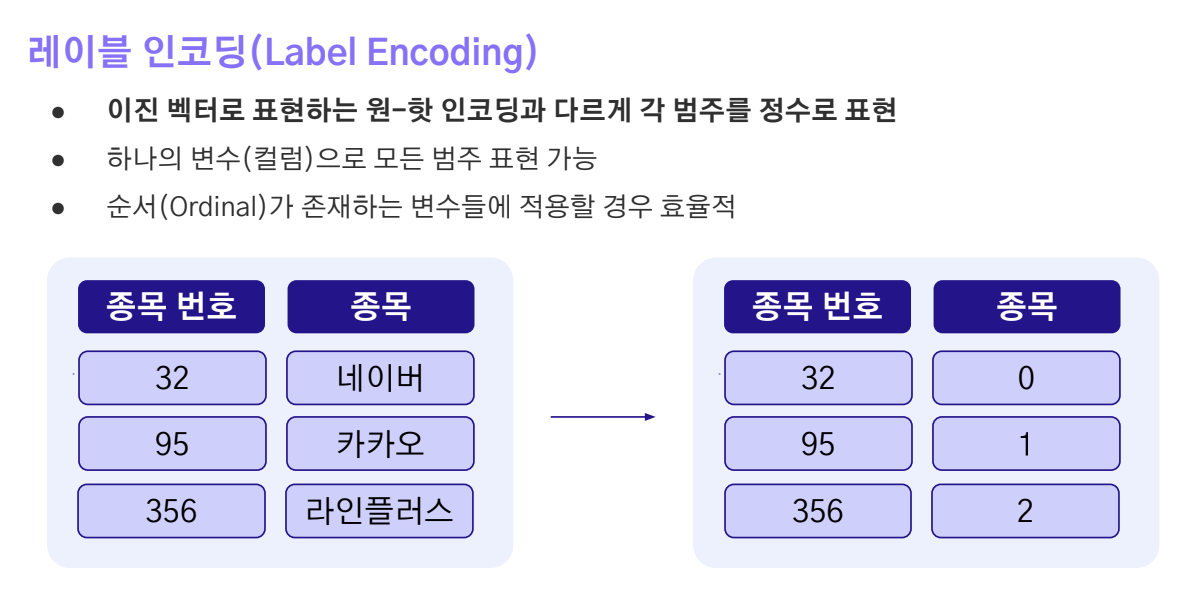

In [84]:
# 구별 평균가격 rank 피처 아래 코드에서 drop으로 삭제예정
# 바로 다음 블록 코드에서 동별 평균가격 rank 피처가 있는데, 그게 성능이 더 좋다

mean_price_by_gu = dt_train.groupby('구')['target'].mean().sort_values()
gu_rank = {gu: rank for rank, gu in enumerate(mean_price_by_gu.index, 1)}

dt_train['구_rank'] = dt_train['구'].map(gu_rank)
dt_test['구_rank'] = dt_test['구'].map(gu_rank)

dt_train.drop('구', axis=1, inplace=True)
dt_test.drop('구', axis=1, inplace=True)

In [85]:
mean_price_by_dong = dt_train.groupby('동')['target'].mean().sort_values()
dong_rank = {dong: rank for rank, dong in enumerate(mean_price_by_dong.index, 1)}

dt_train['동_rank'] = dt_train['동'].map(dong_rank)
dt_test['동_rank'] = dt_test['동'].map(dong_rank)

dt_train.drop('동', axis=1, inplace=True)
dt_test.drop('동', axis=1, inplace=True)

In [86]:
dt_train.columns

Index(['아파트명', '전용면적', '층', '건축년도', '도로명', 'target', '계약년', '계약월',
       'avg_price_by_dong', '구_rank', '동_rank'],
      dtype='object')

In [87]:
# 계약일 피처는 성능에 악영향을 끼치는것으로 보임. 계약년과 계약월이 있어서 삭제해도 괜찮을듯. 계약년과 계약월은 필수다
columns_to_drop = [
    '구_rank'
]

dt_train = dt_train.drop(columns=columns_to_drop)
dt_test = dt_test.drop(columns=columns_to_drop)

In [88]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '층', '건축년도', 'target', 'avg_price_by_dong', '동_rank']
범주형 변수: ['아파트명', '도로명', '계약년', '계약월']


In [89]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:01<00:00,  3.22it/s]


In [90]:
dt_train.head(1)        # 레이블인코딩이 된 모습입니다.

,아파트명,전용면적,층,건축년도,도로명,target,계약년,계약월,avg_price_by_dong,동_rank
0,328,4.394079,3,1987,6176,11.728045,10,11,92107.125518,292


### 5.2. Model Training
- 위 데이터를 이용해 모델을 train 해보겠습니다. 모델은 XGBoost 이용하겠습니다.
- 마크다운에 RandomForest관련 사항은 삭선표시해두었습니다.

In [91]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [92]:
dt_test.shape

(9272, 10)

In [93]:
# 시간이 있다면 K-fold 검증을 해보면 좋다다

# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']

# y_train = np.log1p(dt_train['target'])


X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [94]:
# print(concat_select[concat_select['계약년'] == '2023'])

In [95]:
# dt_train.loc[201006, '계약년']

In [96]:
# # 1. 2023년 거래만 필터링
# transactions_2023 = dt_train[dt_train['계약년'] == dt_train.loc[201006, '계약년']]

# # 2. 아파트별 랜덤으로 2개 샘플링
# random_val_transactions = transactions_2023.groupby('아파트명').apply(
#     lambda x: x.sample(n=2, random_state=2023) if len(x) >= 2 else x
# ).reset_index(drop=True)

# # 3. 검증 데이터로 설정
# X_val = random_val_transactions.drop(['target'], axis=1)
# y_val = random_val_transactions['target']

# # 4. 검증 데이터 제외한 나머지를 학습 데이터로 설정
# X_train = dt_train[~dt_train.index.isin(random_val_transactions.index)].drop(['target'], axis=1)
# y_train = dt_train[~dt_train.index.isin(random_val_transactions.index)]['target']

# # 결과 확인
# print(f"학습 데이터 크기: {X_train.shape}, 검증 데이터 크기: {X_val.shape}")

In [97]:
# import xgboost

# model=xgboost.XGBRegressor(
#     device='gpu'
# )

### 하이퍼파라미터 탐색을 위한 코드

- GridSearch와 RandomSearch 중 선택을 고민했습니다
- GridSearch는 모든 경우의 수를 따져서 시간이 많이 소요되므로 RandomSearch 를 선택했습니다.
- 최적의 하이퍼파라미터를 이미 찾아 아래 코드에서 사용하고있으니 앞으로 실행할 필요는 없습니다.

### 하이퍼파라미터 선택지들

* 현재까지 파악된 제일 좋은 점수를 보이는 하이퍼파라미터는 learningRate=0.05, n_estimator=5000 입니다.
* 하지만 n_estimator변수의 값이 높으면 과적합 우려가 있습니다.
* 추후 EDA가 완료된 후 n_estimator값이 낮은 모델로도 학습 후 테스트가 필요합니다.
* 추가 테스트 결과 early_stopping을 쓰는것이 학습에 더 도움이 됩니다.
* 최적의 학습구간을 스스로 찾고, 과적합이 되기 전에 학습을 중단하기 떄문인것으로 보입니다.

각 하이퍼파라미터별로 상단에 점수를 기재해두었습니다.


In [98]:
# # 기존 하이퍼파라미터와 큰 차이는 없다
import xgboost

model = xgboost.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=10,
    min_child_weight=5,
    booster='gbtree',
    device='cuda',
    base_score=0.5,
    eval_metric='rmse',
    early_stopping_rounds=1000,
)

In [99]:
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

[0]	validation_0-rmse:9.75631
[1]	validation_0-rmse:9.26889
[2]	validation_0-rmse:8.80586
[3]	validation_0-rmse:8.36601
[4]	validation_0-rmse:7.94815
[5]	validation_0-rmse:7.55118
[6]	validation_0-rmse:7.17407
[7]	validation_0-rmse:6.81582
[8]	validation_0-rmse:6.47550
[9]	validation_0-rmse:6.15218
[10]	validation_0-rmse:5.84505
[11]	validation_0-rmse:5.55330
[12]	validation_0-rmse:5.27613
[13]	validation_0-rmse:5.01285
[14]	validation_0-rmse:4.76274
[15]	validation_0-rmse:4.52516
[16]	validation_0-rmse:4.29945
[17]	validation_0-rmse:4.08506
[18]	validation_0-rmse:3.88140
[19]	validation_0-rmse:3.68795
[20]	validation_0-rmse:3.50418
[21]	validation_0-rmse:3.32961
[22]	validation_0-rmse:3.16379
[23]	validation_0-rmse:3.00626
[24]	validation_0-rmse:2.85664
[25]	validation_0-rmse:2.71452
[26]	validation_0-rmse:2.57954
[27]	validation_0-rmse:2.45132
[28]	validation_0-rmse:2.32955
[29]	validation_0-rmse:2.21387
[30]	validation_0-rmse:2.10402
[31]	validation_0-rmse:1.99969
[32]	validation_0-

[50]	validation_0-rmse:0.77086
[51]	validation_0-rmse:0.73409
[52]	validation_0-rmse:0.69920
[53]	validation_0-rmse:0.66613
[54]	validation_0-rmse:0.63480
[55]	validation_0-rmse:0.60513
[56]	validation_0-rmse:0.57700
[57]	validation_0-rmse:0.55041
[58]	validation_0-rmse:0.52519
[59]	validation_0-rmse:0.50137
[60]	validation_0-rmse:0.47879
[61]	validation_0-rmse:0.45747
[62]	validation_0-rmse:0.43729
[63]	validation_0-rmse:0.41823
[64]	validation_0-rmse:0.40025
[65]	validation_0-rmse:0.38327
[66]	validation_0-rmse:0.36722
[67]	validation_0-rmse:0.35210
[68]	validation_0-rmse:0.33784
[69]	validation_0-rmse:0.32439
[70]	validation_0-rmse:0.31155
[71]	validation_0-rmse:0.29955
[72]	validation_0-rmse:0.28835
[73]	validation_0-rmse:0.27789
[74]	validation_0-rmse:0.26801
[75]	validation_0-rmse:0.25869
[76]	validation_0-rmse:0.25006
[77]	validation_0-rmse:0.24202
[78]	validation_0-rmse:0.23444
[79]	validation_0-rmse:0.22732
[80]	validation_0-rmse:0.22042
[81]	validation_0-rmse:0.21426
[82]	val

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=1000,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [100]:
pred = model.predict(X_val)
# pred_log = model.predict(X_val)
# pred = np.expm1(pred_log)

In [101]:
# print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred_log))}')

~~- 포레스트의 하이퍼파라미터도 데이터에 맞게 지정해줄 수 있습니다. 데이터에 맞는 하이퍼파라미터를 찾는 것도 성능 향상에 도움이 될 수 있습니다~~

In [102]:
# y_val = np.expm1(y_val)
# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

RMSE test: 0.08121299682493337


- 변수 중요도도 확인해보도록 하겠습니다.

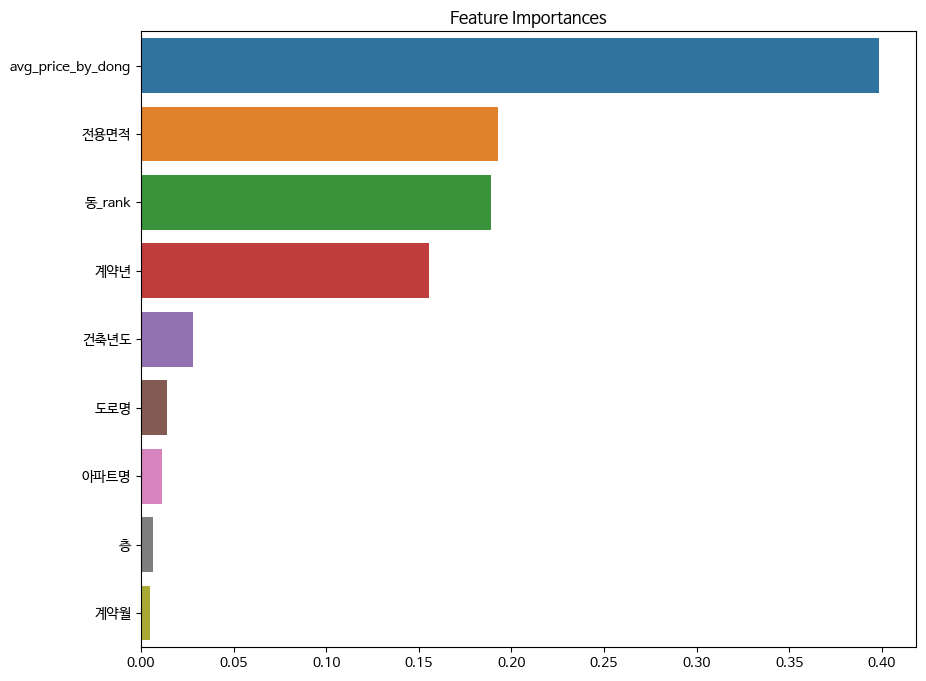

In [103]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [104]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

### 5.3. Feature selection

- 어떤 변수가 유용한 변수인지 확인해보기 위해 permutation selection을 이용해보겠습니다.

In [105]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(model,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())    # valid data에 대해 적합시킵니다.

Weight,Feature
0.2484 ± 0.0008,전용면적
0.1716 ± 0.0009,계약년
0.1561 ± 0.0000,avg_price_by_dong
0.0436 ± 0.0003,건축년도
0.0422 ± 0.0002,동_rank
0.0168 ± 0.0002,도로명
0.0156 ± 0.0001,아파트명
0.0041 ± 0.0000,계약월
0.0037 ± 0.0000,층


- 분석 결과 "계약년", "전용면적" 변수가 유의한 변수로 보입니다. 따라서 이 변수로 또 다른 파생변수를 더 생성해보거나, 중요도가 낮아보이는 변수를 제거해 차원의 저주를 막아볼 수도 있습니다.

### 5.4. Valid prediction 분석

- 예측값을 분석해보기 위해 valid prediction을 확인해보겠습니다.

In [106]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred

In [107]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

In [108]:
# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting

In [109]:
X_val_sort.head(1)

,아파트명,전용면적,층,건축년도,도로명,계약년,계약월,avg_price_by_dong,동_rank,target,pred,error
1054061,1790,4.593715,6,2005,3760,1,1,97129.588587,290,6.216606,10.840051,21.37624


- 예측을 잘 하지 못한 top 100개의 데이터와 예측을 잘한 top 100개의 데이터를 비교해보겠습니다.

In [110]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)       # 예측을 잘한 top 100개의 data

# 따로 로그를 찍기 위해 작성한 코드
# X_val_sort_top100 = X_val.sort_values(by='error', ascending=False)
# X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(1000)

In [111]:
# 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])


# 따로 로그를 찍기 위해 작성한 코드
# error_top100 = X_val_sort_top100.copy()
# for column in categorical_columns_v2 :    
#     error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

# best_top100 = X_val_sort_tail100.copy()
# for column in categorical_columns_v2 :     
#     best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [112]:
display(error_top100.head(2))
display(best_top100.head(2))

,아파트명,전용면적,층,건축년도,도로명,계약년,계약월,avg_price_by_dong,동_rank,target,pred,error
1054061,로얄하이츠,4.593715,6,2005,반포대로3길 45,2008,02,97129.588587,290,6.216606,10.840051,21.376240
1109080,e지브로,4.451786,3,2004,양재대로66길 29,2007,02,65759.340987,249,6.216606,10.351791,17.099757


,아파트명,전용면적,층,건축년도,도로명,계약년,계약월,avg_price_by_dong,동_rank,target,pred,error
514411,동소문현대,4.451086,10,1994,아리랑로5길 50-8,2017,02,43617.158409,130,10.513280,10.513254,6.828841e-10
692169,주공2,3.818152,15,1992,한글비석로14길 8,2014,10,37983.541547,82,9.615872,9.615898,6.753655e-10


In [113]:
# error_temp = error_top100[(error_top100['아파트명']=='상암월드컵파크9단지') & (error_top100['전용면적'] == 84.98)& (error_top100['계약년'] == '2010')]

In [114]:
# error_temp

In [115]:
# t = concat_select[concat_select['is_test'] == 0]
# temp = t[(t['아파트명']=='상림마을6단지푸르지오BL1-7') & (t['전용면적'] == 39.83)]
# temp = t[(t['아파트명']=='상림마을6단지푸르지오BL1-7')]
# temp = t[(t['아파트명']=='한남더힐')]
# temp = concat_select[(concat_select['아파트명']=='상암월드컵파크9단지') & (concat_select['전용면적'] == 84.98)]

In [116]:
# temp = t[(t['아파트명']=='한남더힐') & (t['전용면적'] == 208.478) & (t['계약년'] == '2021')]
# temp = temp.sort_values('전용면적', ascending=True)
# temp = temp[temp['전용면적'] == 59.686]

In [117]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # 아파트명별로 박스플롯 그리기
# plt.figure(figsize=(12, 6))
# sns.boxplot(data=temp, x='아파트명', y='target')
# plt.xticks(rotation=90)
# plt.show()

In [118]:
# temp = concat[(concat['아파트명'] == '상림마을6단지푸르지오BL1-7')&(concat['전용면적'] == 39.8300)]	
# temp = concat[(concat['아파트명'] == '상림마을6단지푸르지오BL1-7')&(concat['target'] == 112000.0)]
# temp = concat_select[concat_select['아파트명'] == '상림마을6단지푸르지오BL1-7']
# temp.head(30)
# temp_sort = temp.sort_values('target', ascending=False)

In [119]:
# temp.head(30)
# temp_sort = temp.sort_values('target', ascending=False)
# temp_sort.head(1)
# temp_sort.value_counts().sum()

- 이제 분포를 비교해보도록 하겠습니다.

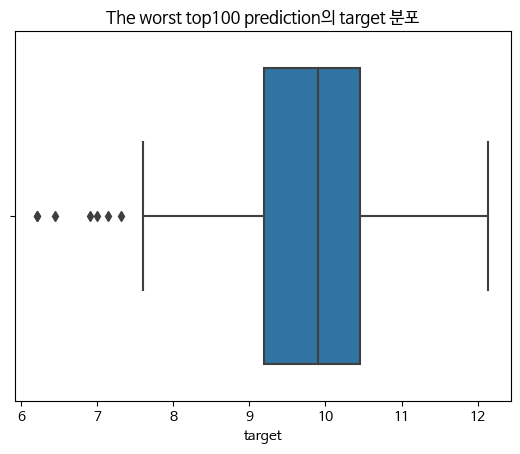

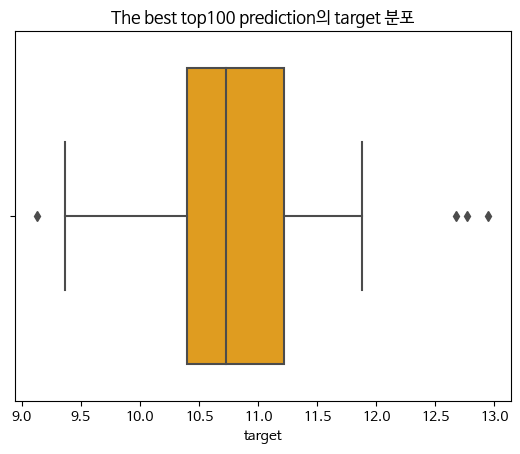

In [120]:
sns.boxplot(data = error_top100, x='target')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.boxplot(data = best_top100, x='target', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

- Taget 분포를 보니 좋은 예측을 보인 top 100개의 data보다 상대적으로 나쁜 예측을 보인 top 100 dataset들이 높은 가격을 보였음을 확인할 수 있습니다. 이에 대한 모델링 및 처리가 필요해보입니다.

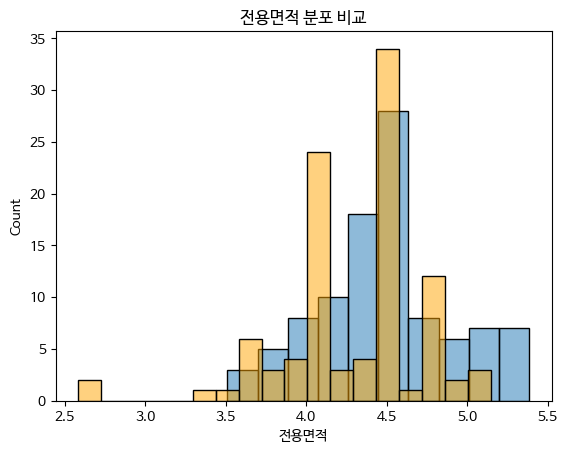

In [121]:
sns.histplot(data = error_top100, x='전용면적', alpha=0.5)
sns.histplot(data = best_top100, x='전용면적', color='orange', alpha=0.5)
plt.title('전용면적 분포 비교')
plt.show()

- 전용면적 또한 나쁜 예측을 보인 집들이 더 넓음을 확인할 수 있습니다.

## 6. Inference

In [122]:
dt_test.head(2)      # test dataset에 대한 inference를 진행해보겠습니다.

,아파트명,전용면적,층,건축년도,도로명,target,계약년,계약월,avg_price_by_dong,동_rank
1118816,328,4.394079,5,1987,6176,0,16,6,92107.125518,292
1118817,329,4.693197,10,2021,469,0,16,7,92107.125518,292


In [123]:
# 저장된 모델을 불러옵니다.
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [124]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
# test_pred = model.predict(X_test)
real_test_pred = model.predict(X_test)
real_test_pred = np.expm1(real_test_pred)

CPU times: user 97.4 ms, sys: 1.44 ms, total: 98.9 ms
Wall time: 29.4 ms


In [125]:
concat_select[concat_select['is_test'] == 1][['아파트명','동','전용면적','계약년','계약월']]

,아파트명,동,전용면적,계약년,계약월
1118816,개포6차우성,개포동,4.394079,2023,07
1118817,개포더샵트리에,개포동,4.693197,2023,08
1118818,개포우성3차,개포동,5.087596,2023,07
1118819,개포우성3차,개포동,4.901267,2023,08
1118820,개포우성3차,개포동,4.658047,2023,08
...,...,...,...,...,...
1128083,신내우디안1단지,신내동,4.450269,2023,07
1128084,신내우디안1단지,신내동,4.449919,2023,07
1128085,신내우디안1단지,신내동,4.631325,2023,08
1128086,신내우디안1단지,신내동,4.453649,2023,09


In [126]:
dt[dt['아파트명'] == '개포우성3차'][['아파트명','시군구','전용면적(㎡)','계약년월', '계약일', 'target']]

,아파트명,시군구,전용면적(㎡),계약년월,계약일,target
12,개포우성3차,서울특별시 강남구 개포동,133.46,201710,13,152000
13,개포우성3차,서울특별시 강남구 개포동,161.00,201711,11,182000
14,개포우성3차,서울특별시 강남구 개포동,161.00,201711,27,170000
15,개포우성3차,서울특별시 강남구 개포동,161.00,201712,13,185000
16,개포우성3차,서울특별시 강남구 개포동,133.46,201712,16,175000
...,...,...,...,...,...,...
966333,개포우성3차,서울특별시 강남구 개포동,104.43,201004,8,90000
1004786,개포우성3차,서울특별시 강남구 개포동,133.46,200711,22,157000
1004787,개포우성3차,서울특별시 강남구 개포동,161.00,200712,20,168510
1004788,개포우성3차,서울특별시 강남구 개포동,104.43,200802,29,102500


In [127]:
dt_test = pd.read_csv(test_path)
print(dt_test[['아파트명','시군구','전용면적(㎡)','계약년월', '계약일']].head(10))
print(dt_test[['아파트명','시군구','전용면적(㎡)','계약년월', '계약일']].tail(10))

       아파트명            시군구   전용면적(㎡)    계약년월  계약일
0    개포6차우성  서울특별시 강남구 개포동   79.9700  202307   26
1   개포더샵트리에  서울특별시 강남구 개포동  108.2017  202308   15
2    개포우성3차  서울특별시 강남구 개포동  161.0000  202307   28
3    개포우성3차  서울특별시 강남구 개포동  133.4600  202308   10
4    개포우성3차  서울특별시 강남구 개포동  104.4300  202308   18
5   개포주공5단지  서울특별시 강남구 개포동   74.2500  202307   28
6   개포주공6단지  서울특별시 강남구 개포동   83.2100  202307    2
7   개포주공6단지  서울특별시 강남구 개포동   73.0200  202308   14
8   개포주공6단지  서울특별시 강남구 개포동   53.0600  202308   24
9  래미안블레스티지  서울특별시 강남구 개포동  126.9280  202307    3
           아파트명            시군구  전용면적(㎡)    계약년월  계약일
9262  송파파인타운9단지  서울특별시 송파구 장지동    59.95  202308   24
9263  송파파인타운9단지  서울특별시 송파구 장지동    59.95  202309    8
9264     종로센트레빌  서울특별시 종로구 숭인동    84.92  202308   26
9265     종로센트레빌  서울특별시 종로구 숭인동    59.92  202309    1
9266         묵정   서울특별시 중구 묵정동    52.46  202309    4
9267   신내우디안1단지  서울특별시 중랑구 신내동    84.65  202307   19
9268   신내우디안1단지  서울특별시 중랑구 신내동    84.62  202307   25
9269   신내우디안1단지  서울특별시 중랑구

In [128]:
print(concat_select[concat_select['is_test']==1].head(10))
print(concat_select[concat_select['is_test']==1].tail(10))

             아파트명      전용면적   층  건축년도       도로명    target  is_test    구    동  \
1118816    개포6차우성  4.394079   5  1987     언주로 3  9.491828        1  강남구  개포동   
1118817   개포더샵트리에  4.693197  10  2021   개포로 311  9.491828        1  강남구  개포동   
1118818    개포우성3차  5.087596  15  1984   개포로 307  9.491828        1  강남구  개포동   
1118819    개포우성3차  4.901267  14  1984   개포로 307  9.491828        1  강남구  개포동   
1118820    개포우성3차  4.658047   6  1984   개포로 307  9.491828        1  강남구  개포동   
1118821   개포주공5단지  4.320816   8  1983  삼성로4길 17  9.491828        1  강남구  개포동   
1118822   개포주공6단지  4.433314  11  1983   개포로 516  9.491828        1  강남구  개포동   
1118823   개포주공6단지  4.304335  12  1983   개포로 516  9.491828        1  강남구  개포동   
1118824   개포주공6단지  3.990095   9  1983   개포로 516  9.491828        1  강남구  개포동   
1118825  래미안블레스티지  4.851468  26  2019     선릉로 8  9.491828        1  강남구  개포동   

          계약년 계약월  avg_price_by_dong  
1118816  2023  07       92107.125518  
1118817  2023  08       92107.125518  
11

In [129]:
print(dt[dt['아파트명'] == '묵정'][['시군구', '아파트명', '전용면적(㎡)', '계약년월','target']])

                  시군구 아파트명  전용면적(㎡)    계약년월  target
213767   서울특별시 중구 묵정동   묵정    52.46  201710   29000
213768   서울특별시 중구 묵정동   묵정    52.46  201804   29000
213769   서울특별시 중구 묵정동   묵정    52.46  201805   28400
213770   서울특별시 중구 묵정동   묵정    52.46  201806   31000
213771   서울특별시 중구 묵정동   묵정    52.46  201806   28300
...               ...  ...      ...     ...     ...
1034987  서울특별시 중구 묵정동   묵정    52.46  201005   21500
1034988  서울특별시 중구 묵정동   묵정    52.46  201005   18800
1118380  서울특별시 중구 묵정동   묵정    52.46  200711   14500
1118381  서울특별시 중구 묵정동   묵정    52.46  200803   16000
1118821  서울특별시 중구 묵정동   묵정    52.46  200701   13250

[82 rows x 5 columns]


In [130]:
# dt_test['전용']

In [131]:
print(concat_select[concat_select['아파트명'] == '개포주공5단지'])

            아파트명      전용면적  층  건축년도       도로명     target  is_test    구    동  \
204      개포주공5단지  4.320816  8  1983  삼성로4길 17  11.767575        0  강남구  개포동   
205      개포주공5단지  4.006969  7  1983  삼성로4길 17  11.566476        0  강남구  개포동   
206      개포주공5단지  4.320816  3  1983  삼성로4길 17  11.775297        0  강남구  개포동   
207      개포주공5단지  4.320816  7  1983  삼성로4길 17  11.779136        0  강남구  개포동   
208      개포주공5단지  4.320816  2  1983  삼성로4길 17  11.726431        0  강남구  개포동   
...          ...       ... ..   ...       ...        ...      ...  ...  ...   
1076073  개포주공5단지  4.006969  4  1983  삼성로4길 17  11.066654        0  강남구  개포동   
1076074  개포주공5단지  4.320816  5  1983  삼성로4길 17  11.561725        0  강남구  개포동   
1076075  개포주공5단지  4.006969  8  1983  삼성로4길 17  11.112463        0  강남구  개포동   
1076076  개포주공5단지  4.006969  1  1983  삼성로4길 17  11.082158        0  강남구  개포동   
1118821  개포주공5단지  4.320816  8  1983  삼성로4길 17   9.491828        1  강남구  개포동   

          계약년 계약월  avg_price_by_dong  
204      201

In [132]:
print(real_test_pred[:10])
print(real_test_pred[-10:])          # 예측값들이 출력됨을 확인할 수 있습니다.

[195406.66 270911.47 322350.   263582.2  210308.84 230346.52 235635.95
 216567.6  187689.48 408541.03]
[108494.33  104904.664  86616.734  74242.68   41272.44   76630.92
  77214.2    84120.41   71793.86   73722.33 ]


In [133]:
# [205000, 245000, 330000, 305000, 249000, 196000, 261000,
#    244000, 199000, 430000]
# [110000 , 80000, 95000 , 84000, 55000, 80000, 
#   71500, 90000, 71800, 80000 ]

In [134]:
pred1 = [205000, 245000, 330000, 305000, 249000, 196000, 261000, 244000, 199000, 430000]
pred2 = [110000 , 80000, 95000 , 84000, 55000, 80000, 71500, 90000, 71800, 80000 ]
print(real_test_pred[:10] - pred1)
print(real_test_pred[-10:] - [pred2])

[ -9593.34375   25911.46875   -7650.       -41417.8125   -38691.15625
  34346.515625 -25364.046875 -27432.40625  -11310.515625 -21458.96875 ]
[[-1.50567188e+03  2.49046641e+04 -8.38326562e+03 -9.75732031e+03
  -1.37275586e+04 -3.36907812e+03  5.71420312e+03 -5.87959375e+03
  -6.14062500e+00 -6.27767188e+03]]


## 7. Output File Save

In [135]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)

In [136]:
# 이상태로 한번 제출,
# 2017 -> 2015 변경 후 한번 제출

In [137]:
rere = pd.read_csv("/data/ephemeral/home/dev/upstage-ml-regression-ml-5/output (1).csv")
print(rere)

      target
0     195216
1     278935
2     334919
3     268479
4     195837
...      ...
9267   73154
9268   73149
9269   82922
9270   68143
9271   72158

[9272 rows x 1 columns]
